#  Chihuahuas oder Muffins

Schaut ob ihr alle Bilder richtig erkennt und dann schauen wir wie gut die künstliche Intelligenz ist.
<img src="Notebook_Images/full.jpg">

# Definitionen und Funktionen für die Künstliche Intelligenz


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

image_height=171
image_width= 171
filename= 'test_data.npz'

def plot(images_to_plot, predictions= np.array([]), titles=[]):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images_to_plot)):
        ax = fig.add_subplot(4, 4, 1 + i, xticks=[], yticks=[])
        im = images_to_plot[i]
        if titles:
            ax.set_title(titles[i])
        if predictions.size:
            ax.set_xlabel('dog: %6.2f \n muffin %6.2f'
                      % (predictions[i][0], predictions[i][1]), fontsize=12)
        plt.imshow(im)
    
    plt.tight_layout()
    plt.show()

# Lade die Bilddaten in den Computer

Die Daten werden nach klassen aufgeteilt:

* \Data
   * \Chihuahuas 
      ...alle Hundefotos
   * \Muffins
      ...alle Muffins
      
      
...und dann in den internen Programmspeicher hochgeladen

In [64]:
data_dir = '/opt/dev/jupyter/Dogs-vs-Muffins/data/chihuahua-muffin'

def load_data(data_dir, img_Size_X, img_size_Y):
        directories = [d for d in os.listdir(data_dir)
                       if os.path.isdir(os.path.join(data_dir, d))]
        labels = []
        category = 0
        file_names = []
        
        print(directories)
        for d in directories:

            label_dir = os.path.join(data_dir, d)
            for path, subdirs, files in os.walk(label_dir):
                for name in files[:150]:
                    if name.endswith(".jpg") or name.endswith(".png") or name.endswith(".jpeg"):
                        os.path.join(path, name)
                        file_names.append(os.path.join(path, name))
                        labels.append(category)

            category += 1

        print(len(file_names))
        data = np.empty((len(file_names), img_Size_X, img_size_Y, 3), dtype=np.uint8)
        for i, fpath in enumerate(file_names):
            img = cv2.imread(fpath)
            img = cv2.resize(img, (img_Size_X, img_size_Y))
            data[i, ...] = img.transpose(0, 1, 2)
        return data, labels

images, labels= load_data(data_dir, image_height, image_width)

# save in numpy .npz format
np.savez_compressed(filename,
                    images=images,
                    labels=labels)

# load from npz
dataset= np.load(file=filename)
labels=dataset['labels']
images=dataset['images']
images= np.concatenate((images[labels ==0][:100], images[labels ==1][:100]) ,axis=0)
labels= np.concatenate((labels[labels ==0][:100], labels[labels ==1][:100]) ,axis=0)
print('load %d files' %len(labels))

['Muffins', 'Chihuahuas', '.ipynb_checkpoints']
16
load 16 files


# Vorbereitung

## Erzeuge weitere Bilder (Augmentierung)

Eigentlich haben wir noch zu wenig Bilder, damit der Computer lernen kann, wie man Hunde von Muffins unterscheidet.

Also wenden wir einige Tricks an und rotieren die Fotos und erzeugen so mehr Daten.

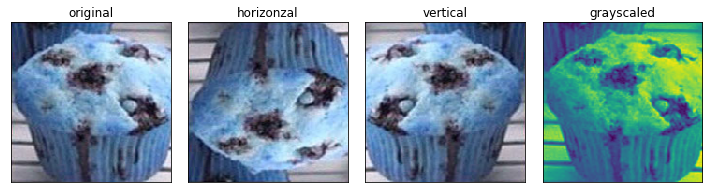

In [65]:
import cv2

img= images[0]

horizontal_flipt= cv2.flip(img, 0)
vertical_flipt= cv2.flip(img, 1)
gray_scaled_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

augmented_images= [img, horizontal_flipt, vertical_flipt, gray_scaled_img]
titels=['original', 'horizonzal', 'vertical', 'grayscaled']
plot(augmented_images, titles=titels)

def randomize_images(images,labels):

    for index in range(len(images)):
        img = images[index]
        flipt_img= cv2.flip(img, np.random.randint(0,1))
        flipt_img = np.expand_dims(flipt_img, axis=0)
        images=np.vstack((images, flipt_img))
        labels = np.append(labels, np.asarray(labels[index]))
    print(len(images))
    return images, labels

Ihr seht, wir haben jetzt mehr Fotos vom gleichen Muffin.

## Bilder zufällig verteilen
Jetzt müssen die Bilder noch vermischt werden, damit das Programm nicht "denkt", es leigt an der Sortierung der Bilder.

In [66]:
from sklearn.utils import shuffle
images , labels = shuffle(images , labels, random_state=9)

# Wie trainiere ich eine künstliche Intelligenz?

Wir haben jetzt mehr daten erzeugt und die Bilder vermischt. 
Jezzt müssen wir die Daten noch aufteilen, damit das Progarmm trainieren kann, ob es die Muffins richtig erkennt. 
D.h. in den Trainingsdaten ist die Information vorhanden was ein Muffin ist und was nicht.
Wenn das Programm "gelernt" hat, die Trainingsphotos richtig zu erkennen, dann werden wir später testen, ob es das auch mit unbeklannten Fotos schafft.

So übt das Programm mit mathematischen Formeln, was richtig war und was falsch.

<img src="Notebook_Images/explanation.png" width="400" >
<cite data-cite="Raschka">


In [67]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

length=len(labels)

X_train = images[:int(length*0.8)]
X_val   = images[int(length*0.8):int(length*0.9)]
X_test  = images[int(length*0.9):]
y_train = labels[:int(length*0.8)] 
y_val   = labels[int(length*0.8):int(length*0.9)]
y_test  = labels[int(length*0.9):]


y_train= np_utils.to_categorical(y_train, 2)
y_val = np_utils.to_categorical(y_val, 2)

print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)
print("Testdaten:", X_test.shape)

Trainingsdaten: (12, 171, 171, 3)
Validierungsdaten: (2, 171, 171, 3)
Testdaten: (2, 171, 171, 3)


## Reduzierung der Ausnahmen

Wir wollen nicht, das einige bunte Felder, das Training beinflussen, wir geben dem Programm quasi ein kleine "Lernhilfe", dass es nicht auf die falschen sachen schaut.


In [68]:
mean_values=np.mean(X_train, axis=0)
std_values=np.std(X_train)

x_train_centered= (X_train- mean_values)/std_values
x_val_centered= (X_val- mean_values)/std_values
x_test_centered= (X_test- mean_values)/std_values

# Jetzt bauen wir das neuronale Netz - das "Gehirn" der künstlichen Intelligenz

Damit wird - grob verinfacht - die Funktionsweise unseres Gehrins nachgebildet.

Nervenzelle (aus dem Biounterricht):

<img src="Notebook_Images/nervenzelle.png" width="400" />


Nervenzellen vernetzt:

<img src="Notebook_Images/neuronen.jpg" width="400" />

Neuronales Netzt als Computermodell:

<img src="Notebook_Images/nn.png" width="400" />


In [69]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import SGD

model = Sequential()
# number of filters (32) and the size of the filter kernels in pixel(5x5) 
# Optionally the initialization and the padding mode can be specified. 

model.add(Convolution2D(32, (5, 5), activation='relu',kernel_initializer='glorot_uniform', padding='same', 
                        input_shape=(image_height, image_width, 3)))
model.add(BatchNormalization())
# After a convolution block a pooling operation follows. The pooling layer in this example has the size 2x2 pixels.
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dense layers are fully connected layers. Here in the example with 512 neurons on this layer. 
# The number of neurons in the last dense layer determines the number of classes to be distinguished.
model.add(Flatten())
model.add(Dense(512,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
# the model has to be compiled. In this case, Categorical-Crossentropy is used as the loss function, Binaray-Crossentropy 
# can be used for a two-class problem. As optimization method stochhastical gradient descent (SGD) is specified, 
# the parameters such as learning rate (lr) can be adjusted during learning.
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',  metrics=['accuracy'])
# With the model.summary command the structure of the model can be printed in the shell.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 171, 171, 32)      2432      
_________________________________________________________________
batch_normalization_16 (Batc (None, 171, 171, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 85, 85, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 85, 85, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 42, 42, 32)        9248      
__________

# Jetzt das Training des "künstlichen Gehirns".

Nachdem wir das Netz gebaut haben  - quasi unser künstliches Gehrin - ist es noch leer.

Also starten wir, es zu trainieren.

Darür gibt es das **"fit"** Kommando. Man kann hier noch ein wenig beeinflussen, wie das Programm lernt.


In [70]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)
earlyStopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# he verbose parameter is be used to determine how ofTten a shell output with current training values 
# should be printed during training.
# Callbacks accepts a list of predefined callback methods, here a callback has been defined which stores the current weightings 
# during the training as soon as the accuracy has increased in an epoch and the loss has fallen. 
# Callbacks can also be defined to store certain values for later visualization or to adapt the learning rate.
model.fit(x_train_centered, y_train,
          batch_size=100,
          epochs=10,
          validation_data=(x_val_centered,  y_val),
          verbose=1,
          callbacks=[checkpointer, earlyStopper, reduce_lr])

Train on 12 samples, validate on 2 samples
Epoch 1/10
12/12 [==============================] - 2s 187ms/step - loss: 1.7547 - acc: 0.5833 - val_loss: 0.2030 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.20301, saving model to model.hdf5
Epoch 2/10
12/12 [==============================] - 0s 38ms/step - loss: 1.0862 - acc: 0.6667 - val_loss: 0.1144 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.20301 to 0.11444, saving model to model.hdf5
Epoch 3/10
12/12 [==============================] - 0s 38ms/step - loss: 0.0665 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.11444 to 0.02018, saving model to model.hdf5
Epoch 4/10
12/12 [==============================] - 0s 39ms/step - loss: 0.0657 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.02018 to 0.00246, saving model to model.hdf5
Epoch 5/10
12/12 [==============================] - 0s 37ms/step - loss: 0.0603 - acc: 1.0000 - val_

## Das Gelernte muss jetzt gespeichert werden, damit es das nicht wieder vergisst.
Jepee, jetzt glaubt das Programm, dass es verstannden hat, wie es geht

In [71]:
# Keras offers several formats like JSON or hdf5.
from keras.models import load_model
model=load_model("model.hdf5")

# Dann also testen wir mal, as es kann

...und lassen es vorhersesagen ("predict")

Erinnert Euch, zuerst haben wir Daten aufgeteilt jetzt kommen die Testdaten dran. Diese wurden beim Training nicht verwendet und jetzt testen wir, ob das Modell wirklich funktioniert


In [78]:
img_to_plot= X_test[:16]
predictions= model.predict(x_test_centered)[:16]
#plot(img_to_plot, predictions= predictions)

true_labels=np_utils.to_categorical(y_test, 2)
metric= model.evaluate(x_test_centered, true_labels)

print('loss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))

2/2 [==============================] - 0s 9ms/step
loss:      10.04  
accuracy:   0.00


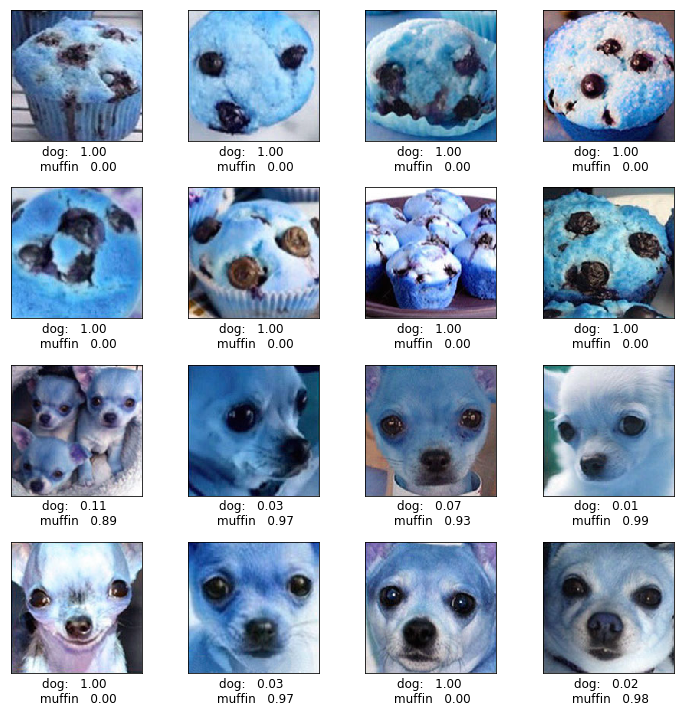

16/16 [==============================] - 0s 9ms/step
loss:       1.27  
accuracy:   0.88


In [79]:
dataset= np.load('test_data.npz')
labels=dataset['labels']
images=dataset['images']

mean_values=np.mean(X_train, axis=0)
std_values=np.std(X_train)

x_test_centered= (images- mean_values)/std_values
plot(images, predictions= model.predict(x_test_centered))

true_labels=np_utils.to_categorical(labels, 2)
metric= model.evaluate(x_test_centered, true_labels)

print('loss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))